***Intro:***
    
Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
The RMSE metric on the test set should not be more than 48.



Project instructions:
Download the data and resample it by one hour.
Analyze the data.
Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
Test the data using the test sample and provide a conclusion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing 
#import models
from sklearn.linear_model import LinearRegression
import lightgbm
import sklearn.model_selection 
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import *
from sklearn.model_selection import *
from sklearn.ensemble import *

from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score

In [2]:
try:
    df = pd.read_csv('datasets/taxi.csv',index_col=[0], parse_dates=[0]) #read csv file stored locally on my laptop
except:
    df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) #make an exception for when I upload the project to Practicum

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
len(df)

26496

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [7]:
df.index.max() # We have about 6 months worth of taxi data

Timestamp('2018-08-31 23:50:00')

In [8]:
df.sort_index(inplace=True) #lets make sure the date is sorted

display(df.head())

df.num_orders.sum()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


372811

In [9]:
print(df.index.is_monotonic) #double checking

True


In [10]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [12]:
df.dropna(inplace=True) #just in case there are NAs

In [13]:
df['2018-07':'2018-08'].head() #experementing with slicing on dates to check if data is a timeseries by hour

,num_orders
datetime,
2018-07-01 00:00:00,11
2018-07-01 00:10:00,10
2018-07-01 00:20:00,13
2018-07-01 00:30:00,23
2018-07-01 00:40:00,19


We see minutes in there so we need to resamble on hour.

In [14]:
df = df.resample('1H').sum()

In [15]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


The mean number of rides per hour is 84 and the median is 78. They look like a normal distribution.

In [16]:
df.sum()

num_orders    372811
dtype: int64

In [17]:
friday_rides = df['2018-06-01']

In [18]:
friday_rides.groupby(friday_rides.index.hour).sum().round() #hourly rides on a typical Friday (busy day)

,num_orders
datetime,
0,118
1,77
2,111
3,132
4,65
5,50
6,22
7,27
8,115


In [19]:
df['num_orders'].groupby(df.index.hour).mean()

datetime
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64

In [20]:
df['hr'] = df.index.hour

In [21]:
df['dayofweek'] = df.index.dayofweek

In [22]:
train_mean, test_mean = train_test_split(df, shuffle=False, test_size=0.1,random_state=77) #Taking 10% for test set

In [23]:
train_mean.head()

,num_orders,hr,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


In [24]:
ref_table = train_mean.groupby(['dayofweek','hr'])['num_orders'].mean()

In [25]:
type(ref_table)

pandas.core.series.Series

In [26]:
ref_table = ref_table.to_frame(name='orders')

In [27]:
ref_table.head(24)

orders
dayofweek hr            
0         0   163.333333
          1   126.666667
          2   125.250000
          3   110.125000
          4    89.458333
          5    46.041667
          6    24.291667
          7    29.333333
          8    71.916667
          9    91.875000
          10  106.208333
          11   91.708333
          12   67.375000
          13   76.833333
          14   69.130435
          15   84.869565
          16  101.043478
          17   85.304348
          18   61.260870
          19   72.130435
          20   62.826087
          21   77.739130
          22   82.565217
          23   86.347826

In [28]:
ref_table.head()

orders
dayofweek hr            
0         0   163.333333
          1   126.666667
          2   125.250000
          3   110.125000
          4    89.458333

In [29]:
test_mean.head()

,num_orders,hr,dayofweek
datetime,,,
2018-08-13 14:00:00,102,14,0
2018-08-13 15:00:00,175,15,0
2018-08-13 16:00:00,144,16,0
2018-08-13 17:00:00,152,17,0
2018-08-13 18:00:00,104,18,0


In [30]:
df_mean_test = pd.merge( test_mean, ref_table, on=['dayofweek','hr'], how='left' )

In [31]:
df_mean_test.head()

,num_orders,hr,dayofweek,orders
0,102,14,0,69.130435
1,175,15,0,84.869565
2,144,16,0,101.043478
3,152,17,0,85.304348
4,104,18,0,61.260870


In [32]:
print('RMSE:', mean_squared_error(df_mean_test['num_orders'], df_mean_test['orders'])**0.5)

RMSE: 74.39749674116383


I'm dropping the extra columns I used for my sanity check from the main df so that the graphs below are cleaner. I will add these columns again later on.

In [33]:
df.drop(['hr','dayofweek'], axis=1, inplace=True)

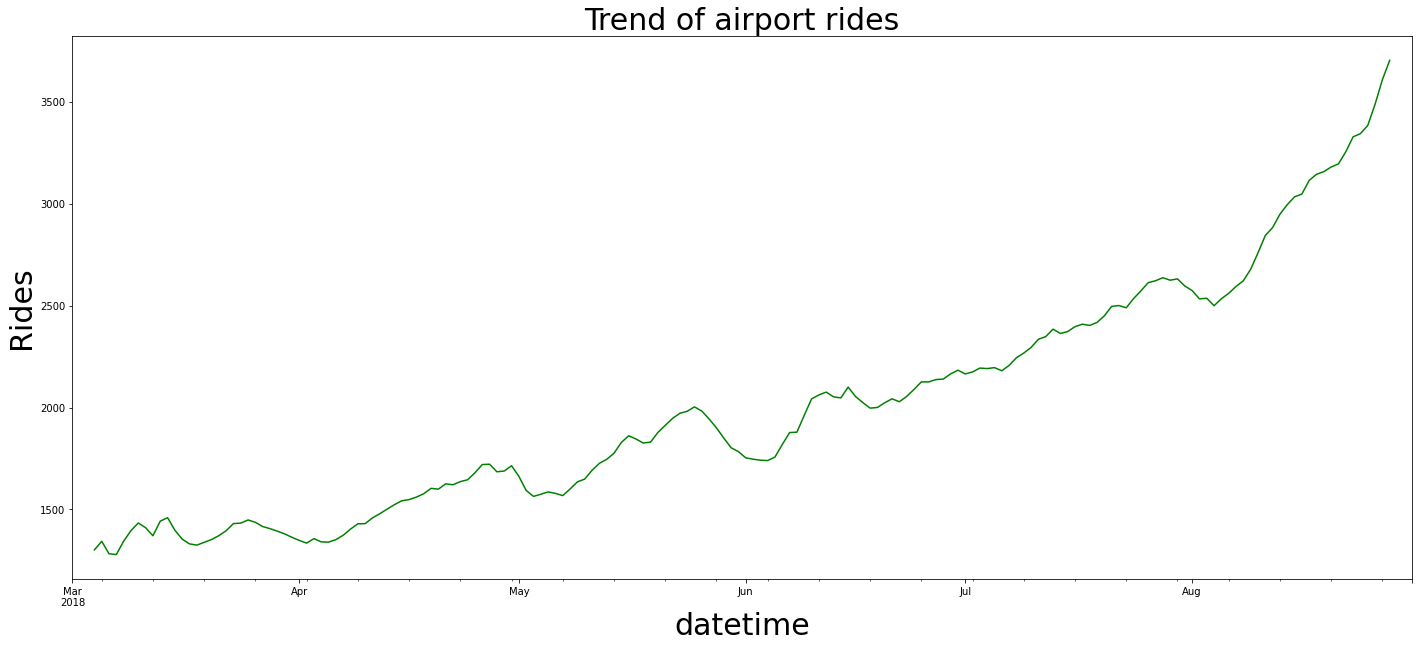

In [34]:

plt.figure(figsize=(24,10))
plt.xlabel('Time', fontsize=30)
plt.ylabel('Rides', fontsize=30)
seasonal_decompose(df.resample('1D').sum().loc[:, 'num_orders']).trend.plot(color='green'); #Business is picking up!
plt.title('Trend of airport rides',fontsize=30);

Lets zoom in on one month to look at seasonality more closely since it looks like a weekly pattern.

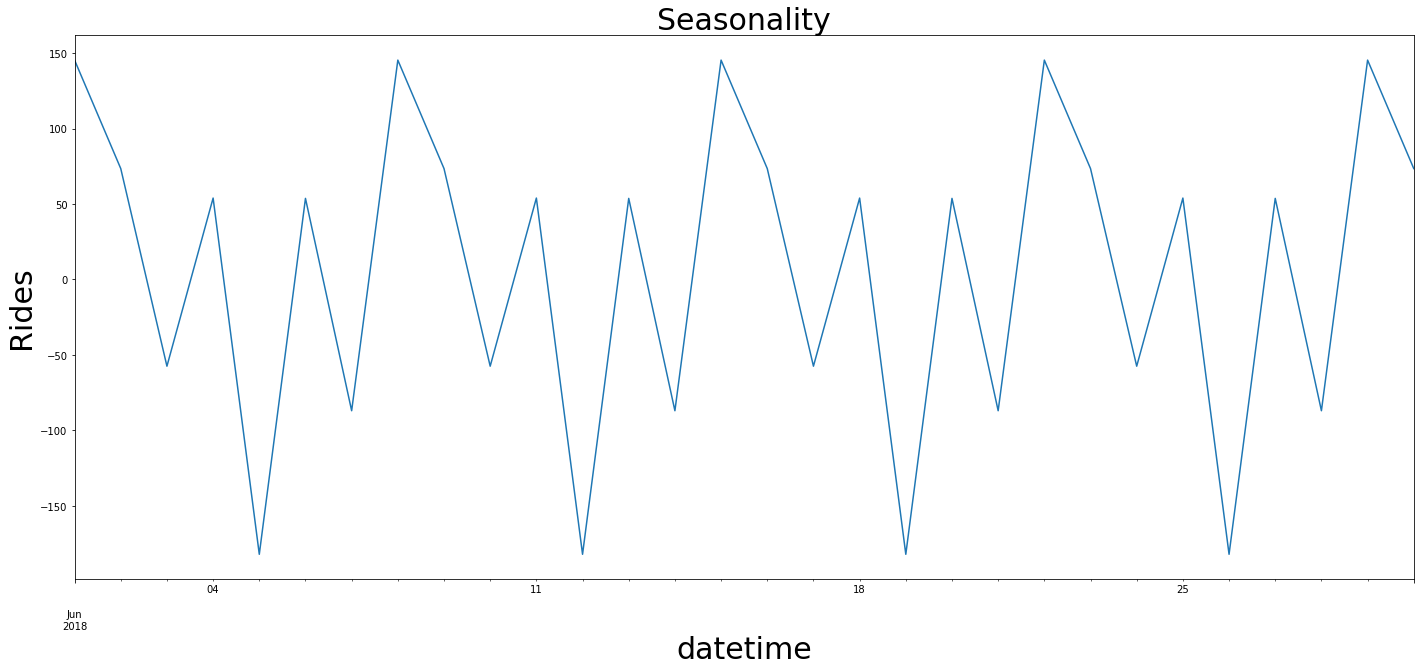

In [35]:
plt.figure(figsize=(24,10))
plt.xlabel('Time', fontsize=30)
plt.ylabel('Rides', fontsize=30)
seasonal_decompose(df['2018-06-01':'2018-06-30'].resample('1D').sum().loc[:, 'num_orders']).seasonal.plot();
plt.title('Seasonality', fontsize=30);

But what specific days are busier than others? We use dayofweek to find out below and plot for entire dataset summed up.

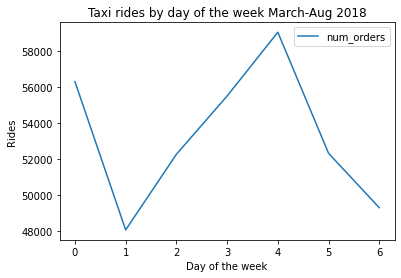

In [36]:
#zooming in to day of week

df.groupby(df.index.dayofweek).sum().plot(); #Zooming into just one months by day.

plt.xlabel('Day of the week', fontsize=10)
plt.ylabel('Rides', fontsize=10)
plt.title('Taxi rides by day of the week March-Aug 2018')
plt.show(block=False);

***We can see seasonality looking at day of the week. Tuesday and Sunday are the lowest and Friday is the highest (party time).***

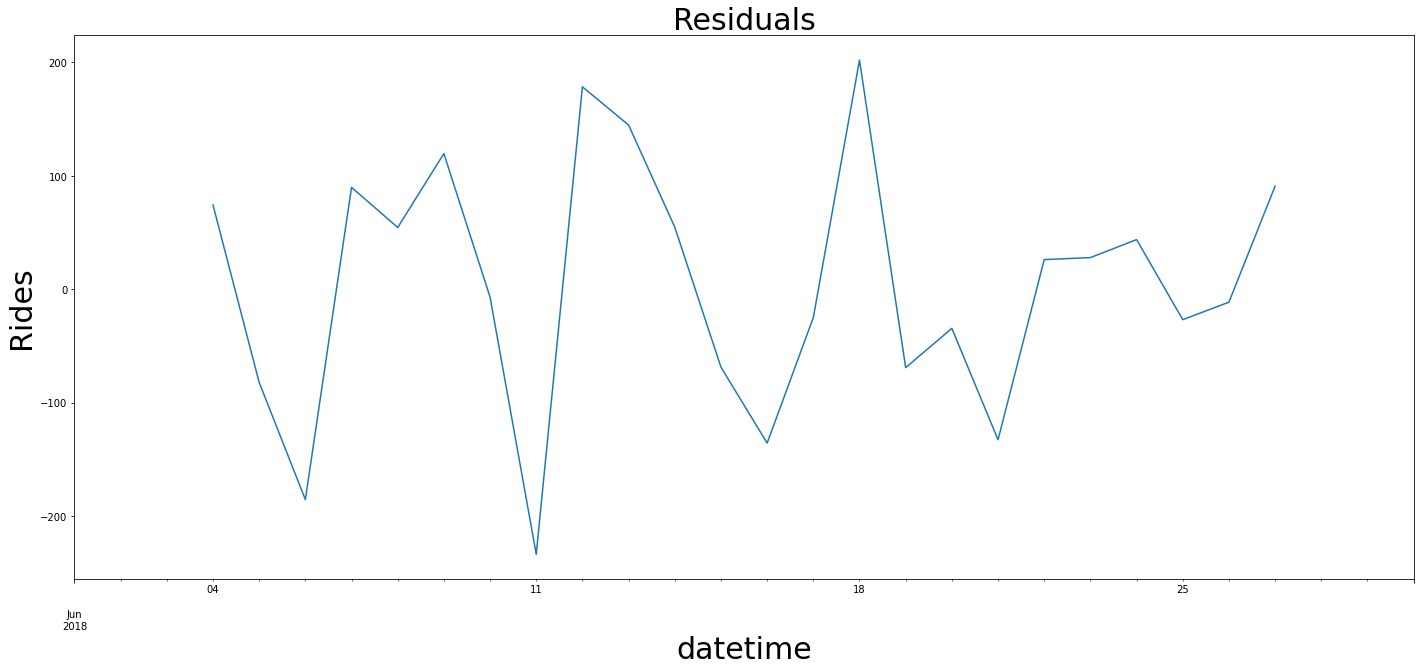

In [37]:
plt.figure(figsize=(24,10)) #plotting residuals -what is left after extracting seasonality and trend
plt.xlabel('Time', fontsize=30)
plt.ylabel('Rides', fontsize=30)
seasonal_decompose(df['2018-06-01':'2018-06-30'].resample('1D').sum().loc[:, 'num_orders']).resid.plot();
plt.title('Residuals', fontsize=30);

Now lets look at rolling averages and moving averages to smooth the data out.

In [38]:
def test_stationary_w(timeseries): #by week
    rolmean = timeseries.rolling(168).mean()# Taking a whole week in hours to smooth out the data
    rolstd = timeseries.rolling(168).std()
    
    plt.figure(figsize=(10,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Dev By rolling week')
    plt.show(block=False)

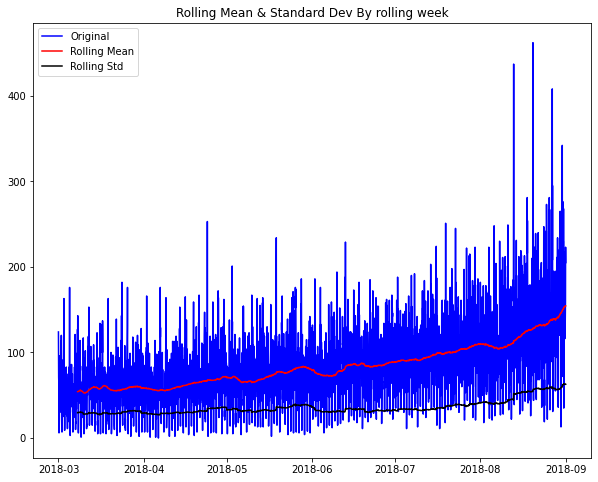

In [39]:
test_stationary_w(df)

In [40]:
def test_stationary_d(timeseries): #by day
    rolmean = timeseries.rolling(24).mean()# Taking day or 24 hrs
    rolstd = timeseries.rolling(24).std()
    
    plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Dev By rolling day')
    plt.show(block=False)

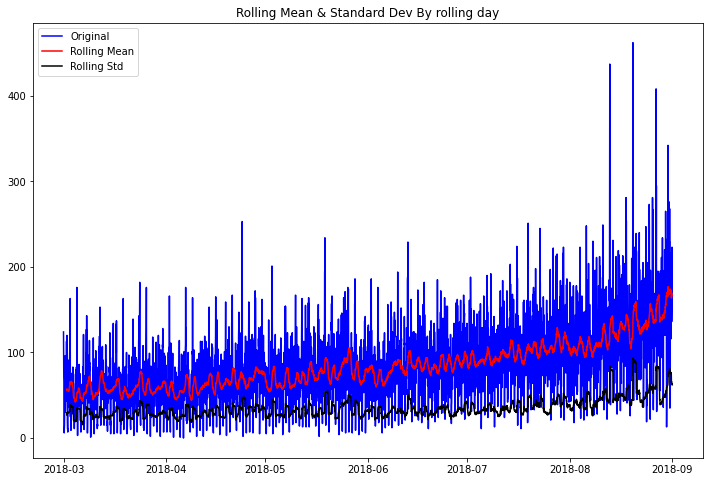

In [41]:
test_stationary_d(df) #we can see the rolling mean is not so smooth comparing day to week graph above

You can see that day of the week seasonality if you graph by day rolling mean but when you do week it smooths it out.

***Conclusions:*** Based on all the graphs and analysis above we can see a strong rising trend and some very marked day of the week seasonality. So this data is not stationary and needs to be treated before feeding it to a Machine Learning model.

Now lets check how stationary the time series is. Out of the two series, the one where the mean and standard deviation change more slowly, is "more stationary".

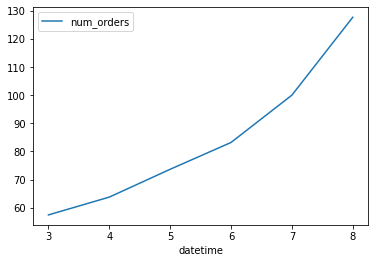

In [42]:
df.groupby(df.index.month).mean().plot();

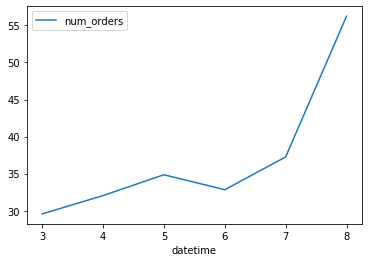

In [43]:
df.groupby(df.index.month).std().plot();

The data does not look stationary at all since over the course of a month the mean and standard deviations for the number of rides to and from airport changes quite significantly. 

From the text: "To make a series stationary, we can take the differences of its values."

In [44]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [45]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Lets try to get more stationary features for training the models and compare.

In [46]:
df_shift = df

In [47]:
df_shift -= df_shift.shift()

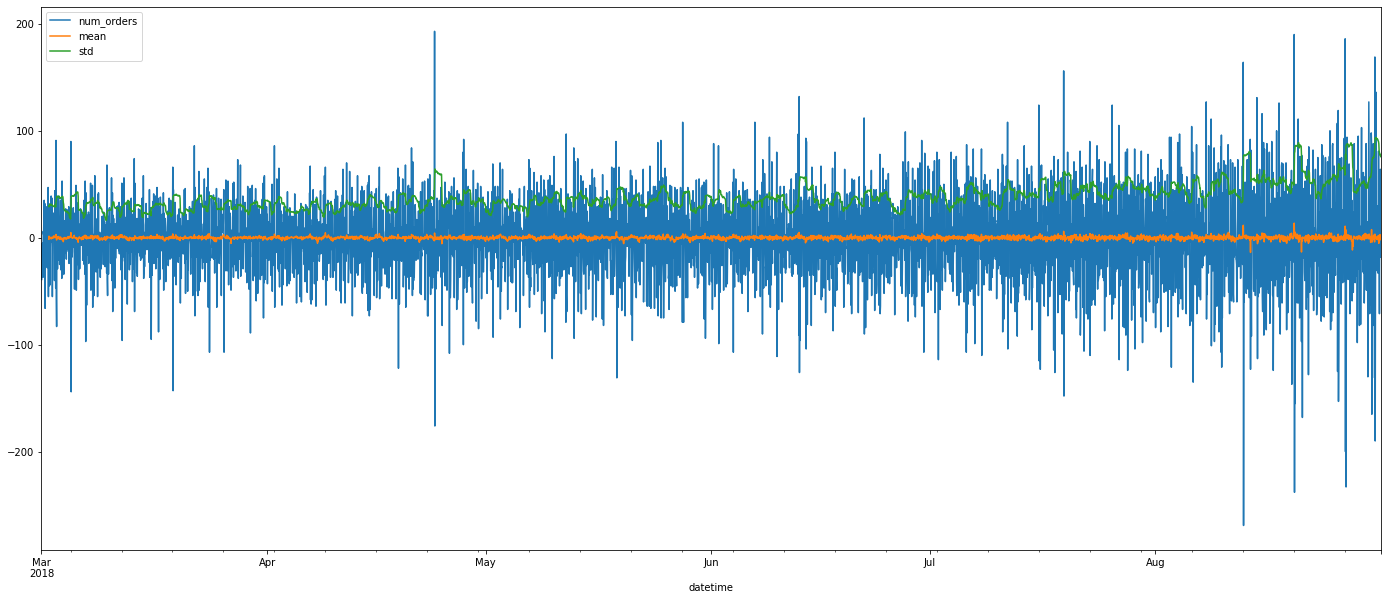

In [48]:
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean() #whole week
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(24,10));

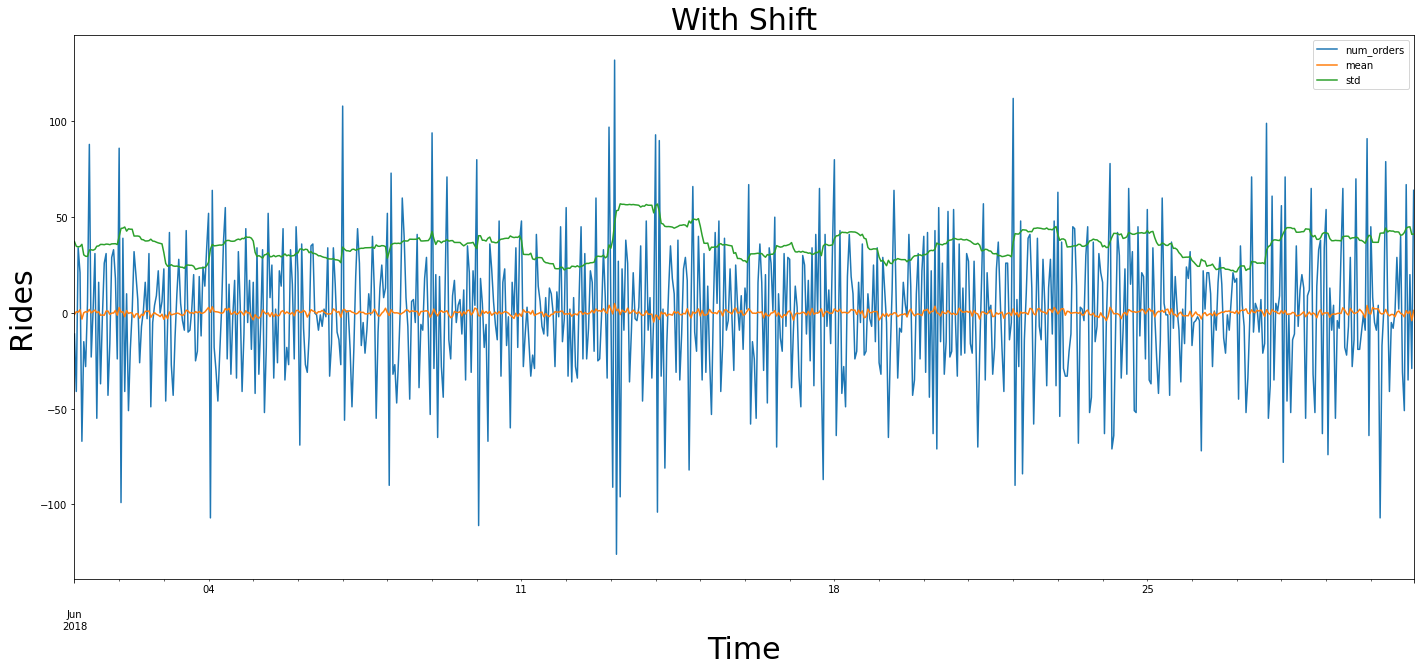

In [49]:
df_shift['2018-06-01':'2018-06-30'].plot(figsize=(24,10));#Zooming in on June.

plt.xlabel('Time', fontsize=30)
plt.ylabel('Rides', fontsize=30)
plt.title('With Shift', fontsize=30);



If we just do a 1 day rolling average the mean gets flat but the standard deviation still changes over time so it is not stationary.

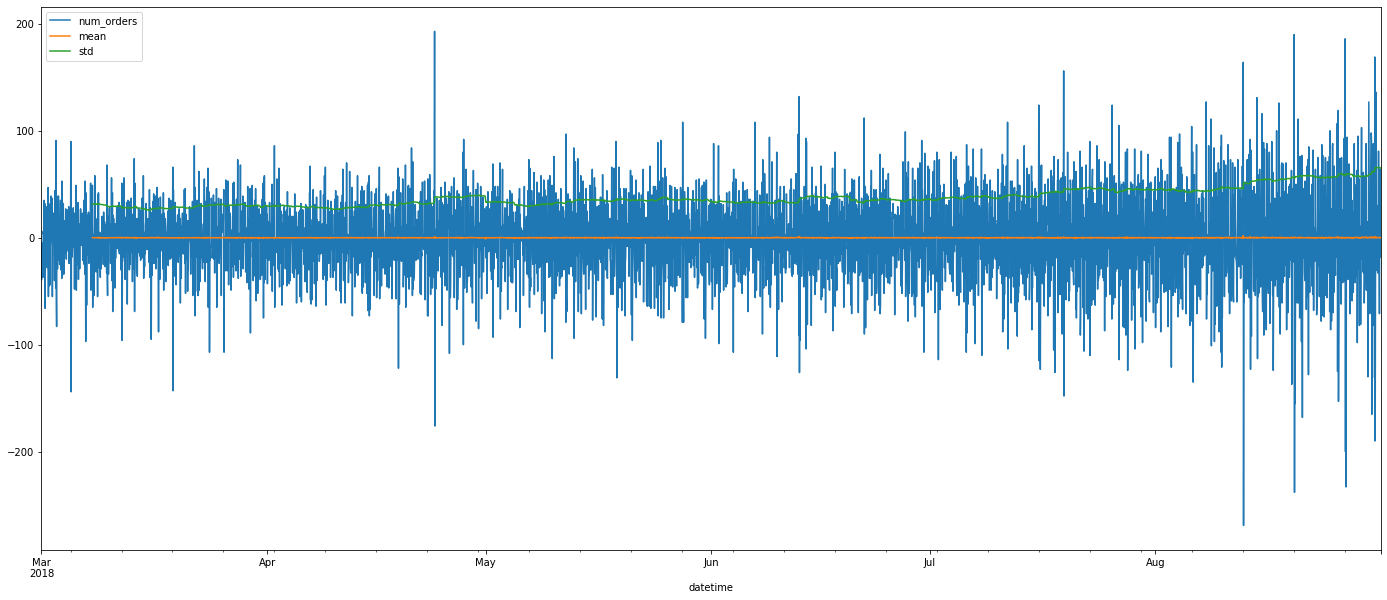

In [50]:
df_shift['mean'] = df_shift['num_orders'].rolling(168).mean() #whole week
df_shift['std'] = df_shift['num_orders'].rolling(168).std()
df_shift.plot(figsize=(24,10));

After rolling on an entire week looks like the data is now a lot more stationary. When we look at weekly rolling mean and std. So I believe we can now proceed to model training.

In [51]:
df.head()

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN


In [52]:
df.describe()

,num_orders,mean,std
count,4415.000000,4248.000000,4248.000000
mean,0.018347,0.023563,37.628639
std,39.023437,0.162449,8.448794
min,-269.000000,-1.023810,25.684231
25%,-22.000000,-0.065476,31.208139
50%,1.000000,0.017857,35.408250
75%,23.000000,0.113095,42.581880
max,193.000000,1.982143,65.975860


In [53]:
df.sum()

num_orders        81.000000
mean             100.095238
std           159846.456459
dtype: float64

In [54]:
train, test = train_test_split(df, shuffle=False, test_size=0.1,random_state=77) #Taking 10% for test set

In [55]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max()) #grabbed the latest dates for the test set

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [56]:
test.describe()

,num_orders,mean,std
count,442.000000,442.000000,442.000000
mean,0.194570,0.090740,56.849483
std,58.922857,0.217468,2.912165
min,-238.000000,-0.654762,50.419893
25%,-36.000000,-0.035714,54.669207
50%,1.500000,0.071429,56.899654
75%,35.000000,0.202381,58.062775
max,190.000000,1.041667,65.975860


In [57]:
print('Median hourly rides:', test['num_orders'].median())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(test, pred_previous)**0.5)

Median hourly rides: 1.5
RMSE: 53.68362559956633


Above is another sanity check or dummy predictions for hourly rides to and from airport. It is greater than 48 RMSE so we have to do better. 

In [58]:
def make_features(data, max_lag, rolling_mean_size):
    data['hr'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 7, 10) #needs to be a week to be stationary

In [59]:
df.head()

,num_orders,mean,std,hr,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN,1,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN,2,3,1,3,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN,3,3,1,3,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN,4,3,1,3,-5.0,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN


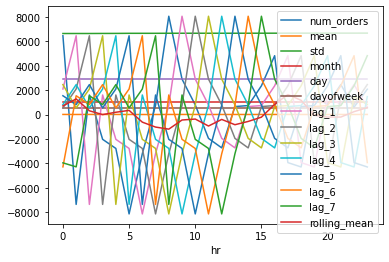

In [60]:
df.groupby('hr').sum().plot(); #This graph just shows the shift or lag in a cool way


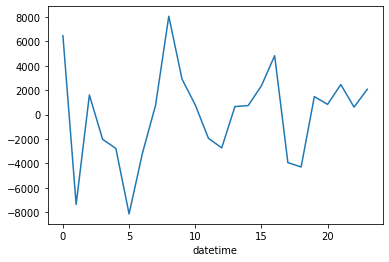

In [61]:
df['num_orders'].groupby(df.index.hour).sum().plot(); #We see the seasonality here by hour

In [62]:
train, test_train = train_test_split(df, shuffle=False, test_size=0.2,random_state=77) #Taking 20% for test set and train set

In [63]:
valid, test = train_test_split(test_train, shuffle=False, test_size=0.5,random_state=77) #10% for test and 10% for valid

In [64]:
test.index.max() 

Timestamp('2018-08-31 23:00:00', freq='H')

In [65]:
test.index.min() 

Timestamp('2018-08-13 14:00:00', freq='H')

In [66]:
valid.index.max() 

Timestamp('2018-08-13 13:00:00', freq='H')

In [67]:
df.describe()

,num_orders,mean,std,hr,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
count,4415.000000,4248.000000,4248.000000,4416.00000,4416.000000,4416.000000,4416.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4405.000000
mean,0.018347,0.023563,37.628639,11.50000,5.505435,15.836957,3.005435,0.022429,0.007931,0.006800,0.002720,0.018821,0.021093,0.016561,0.026856
std,39.023437,0.162449,8.448794,6.92297,1.713306,8.855229,1.990684,39.026915,39.019449,39.023799,39.027283,39.017055,39.021188,39.024455,5.452273
min,-269.000000,-1.023810,25.684231,0.00000,3.000000,1.000000,0.000000,-269.000000,-269.000000,-269.000000,-269.000000,-269.000000,-269.000000,-269.000000,-37.100000
25%,-22.000000,-0.065476,31.208139,5.75000,4.000000,8.000000,1.000000,-22.000000,-22.000000,-22.000000,-22.000000,-22.000000,-22.000000,-22.000000,-3.500000
50%,1.000000,0.017857,35.408250,11.50000,5.500000,16.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.300000
75%,23.000000,0.113095,42.581880,17.25000,7.000000,23.250000,5.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,3.300000
max,193.000000,1.982143,65.975860,23.00000,8.000000,31.000000,6.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,31.500000


In [68]:
train = train.dropna()

In [69]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']
X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

In [70]:
X_train.head()

,mean,std,hr,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-08 00:00:00,0.113095,31.164702,0,3,8,3,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,3.9
2018-03-08 01:00:00,-0.041667,31.423580,1,3,8,3,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,10.0
2018-03-08 02:00:00,-0.035714,31.421015,2,3,8,3,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,2.7
2018-03-08 03:00:00,0.011905,31.419508,3,3,8,3,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,1.9
2018-03-08 04:00:00,0.101190,31.375004,4,3,8,3,3.0,-13.0,-65.0,49.0,-33.0,19.0,32.0,2.0


In [71]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_valid = model_lr.predict(X_valid)


print(
    'RMSE for the training set:', mean_squared_error(y_valid, pred_valid)**0.5 #Taking square root to get RMSE
)


RMSE for the training set: 36.365495840032175


In [80]:
def rmse (y, a):
    return mean_squared_error(y, a)**0.5 #creating an rmse function which is just the squared root of mse

In [81]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [82]:
tscv = TimeSeriesSplit(n_splits=5) #need to make sure we use this in our cross validation
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [83]:
search_space_dtr = {
    "max_depth" : [3,6,10,20],
    "n_estimators" : [10, 20, 30],
    "min_samples_split": [2,4]
} #This will be used to try differnet depths in the decision trees and number of trees
rfr_model = RandomForestRegressor(random_state = 77)

In [84]:

G_S_rfr = GridSearchCV(estimator = rfr_model,
                  param_grid = search_space_dtr, #change the search_space variable for dtr
                  scoring= rmse_score,
                  cv = tscv, #cross validation
                  verbose = 4) 

In [85]:
G_S_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 2/5] END max_depth=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 4/5] END max_depth=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 5/5] END max_depth=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV 1/5] END max_depth=3, min_samples_split=2, n_estimators=30; total time=   0.1s
[CV 2/5] END max_depth=3,

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=77),
             param_grid={'max_depth': [3, 6, 10, 20],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 20, 30]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=4)

In [86]:
G_S_rfr.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_split=4, n_estimators=30,
                      random_state=77)

In [87]:
G_S_rfr.best_score_

-23.939323578182645

In [88]:
G_S_rfr.best_params_

{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 30}

The RandomForest did better than all other models so I will use the best hyperparameters and fit with the test set then check RMSE.

In [89]:
display(G_S_rfr.best_params_)
best_params = G_S_rfr.best_params_

{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 30}

In [90]:
rfr_best = RandomForestRegressor(max_depth= 10, min_samples_split= 4, n_estimators= 10, random_state = 77).fit(X_train, y_train)

In [91]:
pred_valid = rfr_best.predict(X_valid)
print('RMSE for the test set:', rmse(y_valid, pred_valid)) #using same scorer

RMSE for the test set: 32.90741911070522


In [92]:
pred_test = rfr_best.predict(X_test)
print('RMSE for the test set:', rmse(y_test, pred_test)) #using same scorer

RMSE for the test set: 45.383346053375185


### Conclusions:

We got the best RMSE of 32 using the RandomForestRegressor model for the validation set and 45 for the test set. This gives Sweet Lift Taxi the chance to forecast their hourly drivers and staff to prepare ahead of time for demand on rides to and from the airport. This means they can predict rides plus or minus 32 rides of error. I don't believe this will be acceptable for them since the mean number of rides per hour is 84. So at 32 it's quite a significant number of rides to potentially have an error in the predictions compared to the mean. The prediction could be quite a big percentage of the mean plus or minus so it would be hard to staff or plan with this prediction but it is definitely better than having nothing.  I would definitely give potential drivers a good guess to work during predicted peak times. Much better than the driver having to guess and just working random hours without a clue of potential peak demand times.
